# 1. Data Uploading & Initial Exploration

## Goal
Load the hourly energy consumption dataset and do an initial check of structure and basic stats.

## Dataset Info
- **File:** `AEP_hourly_2.csv`
- **Granularity:** Hourly readings
- **Columns:**
  - `Datetime` → timestamp of measurement
  - `AEP_MW` → energy usage in megawatts (MW)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet


In [8]:
URL='AEP_hourly 2.csv'
df=pd.read_csv(URL)

In [9]:
df.head(10)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


**Takeaway:**  
First 10 rows confirm correct datetime format and expected MW values (~12,500–14,900 MW in this sample).


In [10]:
df.shape

(121273, 2)

**Result:** `121,273 rows × 2 columns` — large dataset, hourly resolution over multiple years.


In [11]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


## Summary Statistics

- **Count:** 121,273 hourly records  
- **Mean usage:** ~15,500 MW  
- **Standard deviation:** ~2,591 MW (moderate variability)  
- **Min / Max:** 9,581 MW → 25,695 MW (wide range suggests possible seasonal or peak events)  
- **25% / 50% / 75% quartiles:**  
  - 25%: 13,630 MW  
  - Median: 15,310 MW  
  - 75%: 17,200 MW  

**Takeaway:** The dataset shows substantial variation in hourly energy usage, with peaks exceeding 25 GW. This variability indicates potential daily/seasonal patterns worth exploring in EDA.


# 2. Data Cleaning & Preprocessing
Convert `Datetime` to datetime format for time-based analysis and plot full series.



In [12]:
#changing type of the Datetime column
df['Datetime']=pd.to_datetime(df['Datetime'])

In [13]:
df.head(5)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


**Takeaway:** Datetime successfully converted for easier resampling and feature extraction.


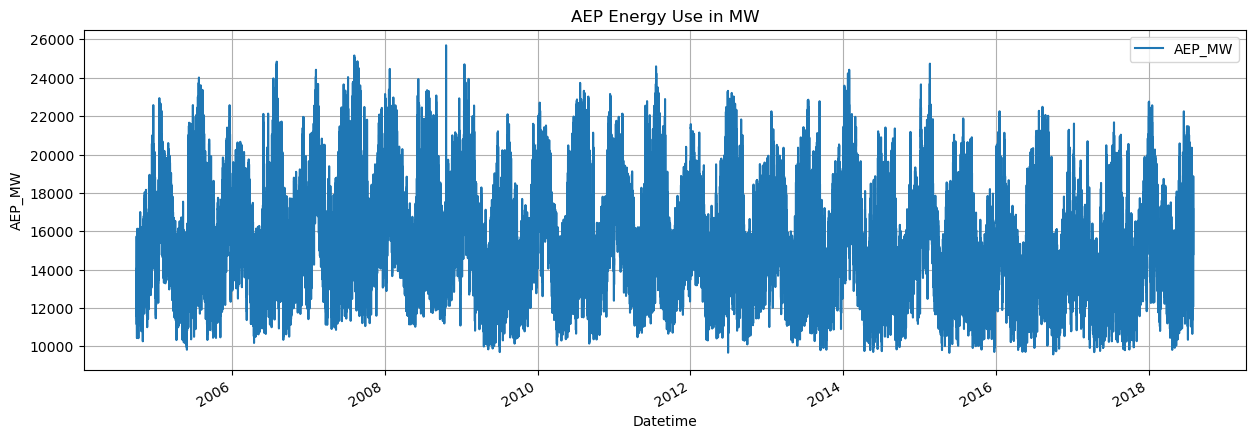

In [14]:

color = sns.color_palette()

# Set Datetime as index for plotting
df.set_index('Datetime', inplace=True)

df[['AEP_MW']].plot(
    style='-', 
    figsize=(15, 5), 
    color=color[0], 
    title='AEP Energy Use in MW'
)

plt.xlabel("Datetime")
plt.ylabel("AEP_MW")
plt.grid(True)
plt.show()

**Observation:** Clear recurring seasonal patterns; usage ranges from ~9,500 MW to ~25,600 MW, likely driven by seasonal demand peaks.

# 3. Feature Extraction from Datetime
Extract additional time-based features to support seasonality and trend analysis.


In [9]:
#Creating new columns by seperating Datetime column as Date, Time, Year, Month, Day, Weekdays
df['Date']=df['Datetime'].dt.date
df['Date']=pd.to_datetime(df['Date'])
df['Time']=df['Datetime'].dt.time


# Extract year, month, day and hour into separate columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Weekday_name'] = df['Date'].dt.day_name()
df['Weekday'] = df['Date'].dt.weekday

In [10]:
df.head(10)

,Datetime,AEP_MW,Date,Time,Year,Month,Day,Hour,Weekday_name,Weekday
0,2004-12-31 01:00:00,13478.0,2004-12-31,01:00:00,2004,12,31,1,Friday,4
1,2004-12-31 02:00:00,12865.0,2004-12-31,02:00:00,2004,12,31,2,Friday,4
2,2004-12-31 03:00:00,12577.0,2004-12-31,03:00:00,2004,12,31,3,Friday,4
3,2004-12-31 04:00:00,12517.0,2004-12-31,04:00:00,2004,12,31,4,Friday,4
4,2004-12-31 05:00:00,12670.0,2004-12-31,05:00:00,2004,12,31,5,Friday,4
5,2004-12-31 06:00:00,13038.0,2004-12-31,06:00:00,2004,12,31,6,Friday,4
6,2004-12-31 07:00:00,13692.0,2004-12-31,07:00:00,2004,12,31,7,Friday,4
7,2004-12-31 08:00:00,14297.0,2004-12-31,08:00:00,2004,12,31,8,Friday,4
8,2004-12-31 09:00:00,14719.0,2004-12-31,09:00:00,2004,12,31,9,Friday,4
9,2004-12-31 10:00:00,14941.0,2004-12-31,10:00:00,2004,12,31,10,Friday,4


**Takeaway:** Added granular time features (`Year`, `Month`, `Day`, `Hour`, `Weekday`) for grouping, aggregation, and seasonality checks.


In [11]:
df.dtypes

Datetime        datetime64[ns]
AEP_MW                 float64
Date            datetime64[ns]
Time                    object
Year                     int32
Month                    int32
Day                      int32
Hour                     int32
Weekday_name            object
Weekday                  int32
dtype: object

**Result:** Datetime-related columns stored as appropriate types (`datetime64` for dates, `int` for numeric parts, `object` for names), ensuring compatibility with time-series operations.


# 4. Exploratory Pairplot
Visualize distributions and relationships between energy usage and time components to spot patterns by weekday.


In [12]:
sns.set_style('darkgrid')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

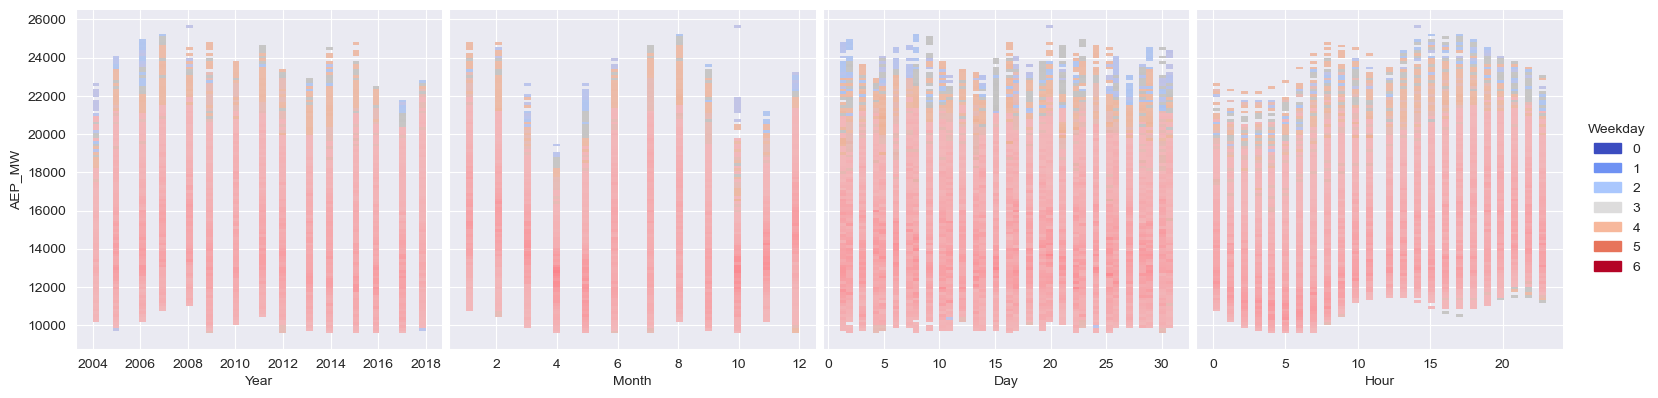

In [13]:
#Sketching pairplot to see the general situation 
sns.pairplot(df,
            hue= 'Weekday',
            y_vars=['AEP_MW'],
            x_vars= ['Year', 'Month', 'Day','Hour'],
            kind='hist',
            palette='coolwarm',
            height=4)

# 5. Monthly Seasonality
Check if energy usage rises/falls in specific months.


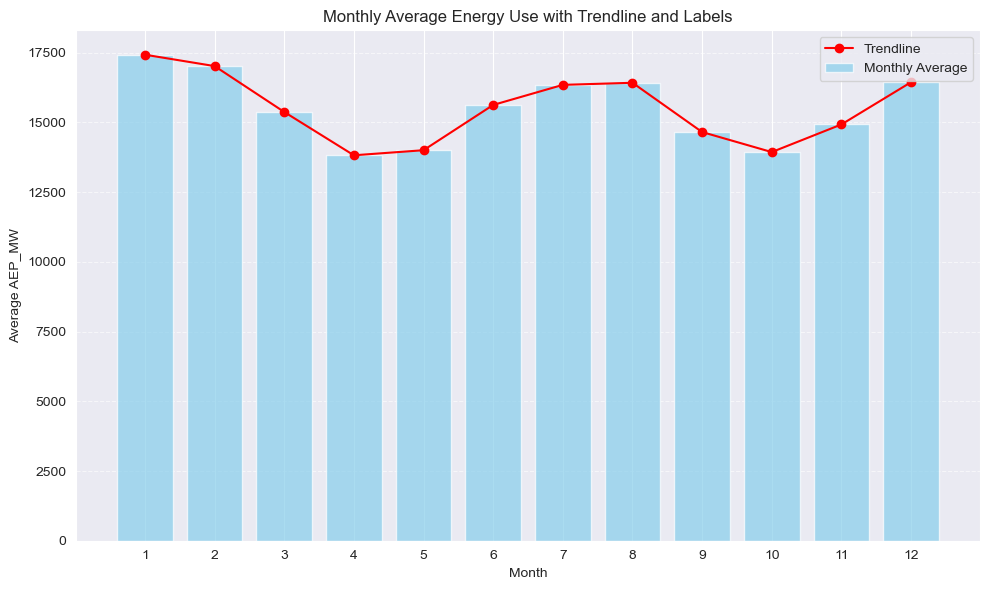

In [14]:
#Monthly Seasonality — Does usage rise/fall in specific months?

# 1. Monthly averages
grouped_df_by_month = df.groupby('Month')['AEP_MW'].mean()

# 2. Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_df_by_month.index, grouped_df_by_month.values, 
               color='skyblue', alpha=0.7, label='Monthly Average')

# 3. Add red trendline
plt.plot(grouped_df_by_month.index, grouped_df_by_month.values, 
         color='red', marker='o', linestyle='-', label='Trendline')



# 5. Titles and grid
plt.title('Monthly Average Energy Use with Trendline and Labels')
plt.xlabel('Month')
plt.ylabel('Average AEP_MW')
plt.xticks(range(1, 13))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### The dataset exhibits clear monthly seasonality, with energy demand peaking during extreme weather months (summer & winter), and dipping during transitional seasons (spring, fall).

- Energy usage is highest in *January, February, July, and December*.

- Lowest usage occurs around April and May, indicating milder weather months with reduced heating/cooling demand.

This suggests strong seasonal effects likely tied to:

Heating needs in winter (Jan, Feb, Dec)

Cooling needs in summer (Jul)


# 6. Seasonal Analysis
Group months into seasons to compare energy usage patterns.


<Axes: xlabel='Season', ylabel='AEP_MW'>

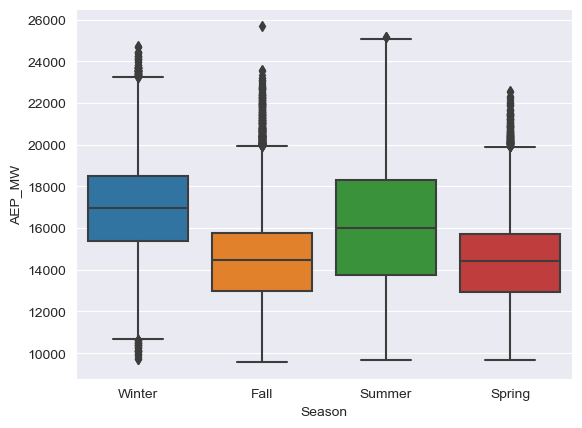

In [15]:
df['Season'] = df['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

sns.boxplot(x='Season', y='AEP_MW', data=df)


**Observation:**  
- **Highest median usage:** Winter & Summer (heating and cooling peaks).  
- **Lowest median usage:** Spring & Fall (mild weather, reduced demand).  
- Wider spread in Summer indicates more variability, possibly due to irregular heatwaves.


In [16]:
df

,Datetime,AEP_MW,Date,Time,Year,Month,Day,Hour,Weekday_name,Weekday,Season
0,2004-12-31 01:00:00,13478.0,2004-12-31,01:00:00,2004,12,31,1,Friday,4,Winter
1,2004-12-31 02:00:00,12865.0,2004-12-31,02:00:00,2004,12,31,2,Friday,4,Winter
2,2004-12-31 03:00:00,12577.0,2004-12-31,03:00:00,2004,12,31,3,Friday,4,Winter
3,2004-12-31 04:00:00,12517.0,2004-12-31,04:00:00,2004,12,31,4,Friday,4,Winter
4,2004-12-31 05:00:00,12670.0,2004-12-31,05:00:00,2004,12,31,5,Friday,4,Winter
...,...,...,...,...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,2018-01-01,20:00:00,2018,1,1,20,Monday,0,Winter
121269,2018-01-01 21:00:00,20999.0,2018-01-01,21:00:00,2018,1,1,21,Monday,0,Winter
121270,2018-01-01 22:00:00,20820.0,2018-01-01,22:00:00,2018,1,1,22,Monday,0,Winter
121271,2018-01-01 23:00:00,20415.0,2018-01-01,23:00:00,2018,1,1,23,Monday,0,Winter


# 7. Monthly Trends Across Years
Compare monthly energy usage patterns over multiple years to confirm seasonality.


<Axes: title={'center': 'Monthly Trend Over Years'}, xlabel='Month'>

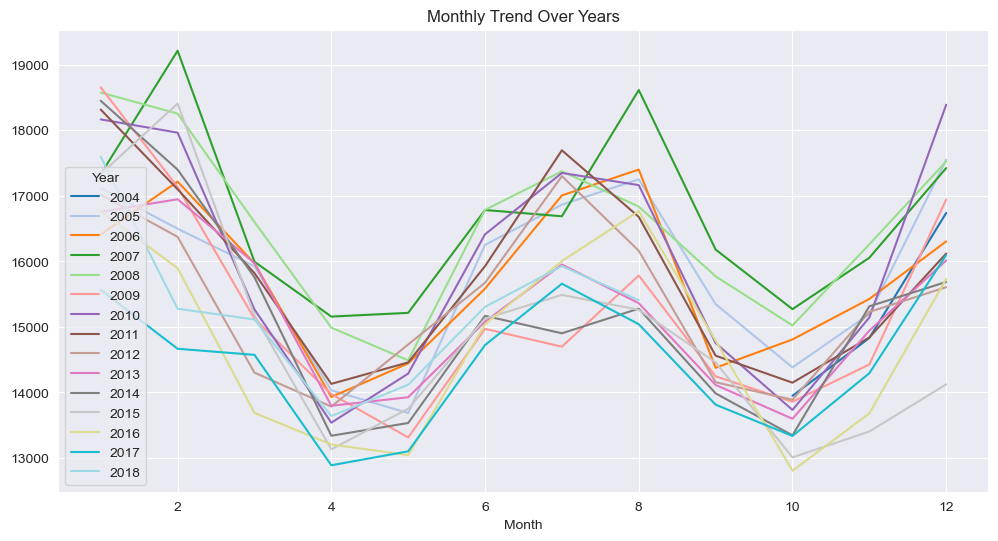

In [17]:
#Grouping  the data on year and month at the same time to see trends for months 

grouped_monthly_yearly = df.groupby(['Year', 'Month'])['AEP_MW'].mean().unstack(level=0) 
grouped_monthly_yearly.plot(figsize=(12,6), title="Monthly Trend Over Years", colormap='tab20')


**Observation:**  
- Peaks consistently in **January** and **July/August**.  
- Dips in **April–May** and **October**.  
- Seasonal pattern repeats yearly → confirms strong seasonality.  
- Slightly higher peaks in years like **2007** and **2016** suggest extreme weather effects.  
- Overall trend is stable from 2004–2018.


# 8. Weekday vs Weekend Behavior
Analyze hourly patterns to see differences between weekdays and weekends.


<Axes: xlabel='Weekday_name', ylabel='Hour'>

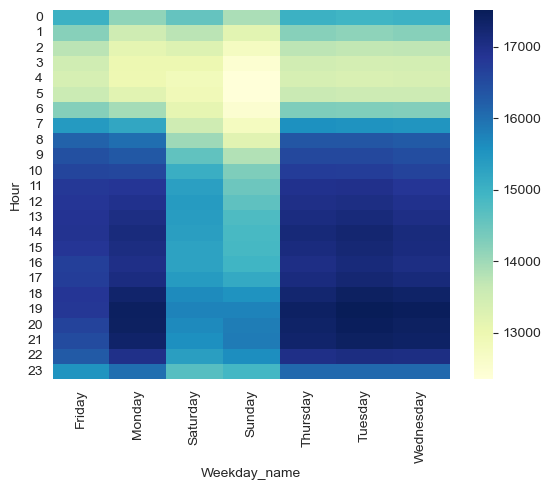

In [18]:
#Weekday vs Weekend Behavior

grouped_hourly_weekday = df.groupby(['Hour', 'Weekday_name'])['AEP_MW'].mean().unstack(level=-1)

sns.heatmap(grouped_hourly_weekday, cmap='YlGnBu', annot=False) 

**Observation:**  
- Energy usage peaks daily between **6 AM and 8 AM**
- **Lower usage during mid-afternoon** hours
- **Weekends (Sat, Sun)** show distinct patterns with **later peak hours** and **slightly higher overnight usage**
- Fridays show a blend of weekday and weekend behavior




# 9. Weekday vs Weekend in Summer vs Winter
Compare hourly energy usage patterns between weekdays and weekends for different seasons.


<Axes: title={'center': 'Winter: Weekday vs Weekend Usage'}, xlabel='Hour'>

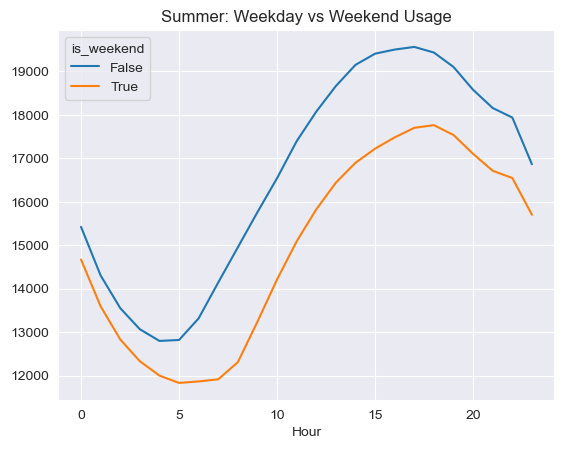

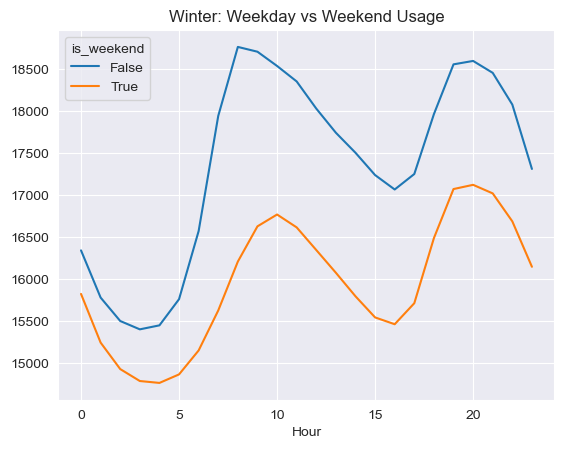

In [19]:
#Weekday vs Weekend in Summer vs Winter

df['is_weekend']=df['Weekday'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5:True, 6: True})
df_summer =  df[df['Season']=='Summer']
df_winter =  df[df['Season']=='Winter']


summer = df_summer.groupby(['is_weekend', 'Hour'])['AEP_MW'].mean().unstack(level=0)
summer.plot(title='Summer: Weekday vs Weekend Usage')

winter = df_winter.groupby(['is_weekend', 'Hour'])['AEP_MW'].mean().unstack(level=0)
winter.plot(title='Winter: Weekday vs Weekend Usage')



**Observation:**  
- **Summer:**  
  - Weekdays peak mid-afternoon (~15:00).  
  - Weekends have lower peaks and slightly flatter curves.  
- **Winter:**  
  - Weekday peaks in morning (~09:00) and evening (~20:00).  
  - Weekend patterns are flatter with later morning peaks.  
- Indicates seasonal shifts in daily demand cycles due to heating/cooling needs.


# 10. Prophet Model Forecasting
Train a Prophet model to forecast daily energy usage and compare against actual test data.

In [20]:
df_daily = df.groupby('Date')['AEP_MW'].mean().reset_index()
df_daily.columns = ['ds', 'y']


In [25]:
#spliting train and test set. 
test_size = 30

train = df_daily[:-test_size]
test = df_daily[-test_size:]


In [26]:
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True
)
model.fit(train)

10:12:01 - cmdstanpy - INFO - Chain [1] start processing
10:12:01 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Create future dataframe with test period
future = model.make_future_dataframe(periods=test_size)

# Forecast into the test period
forecast = model.predict(future)


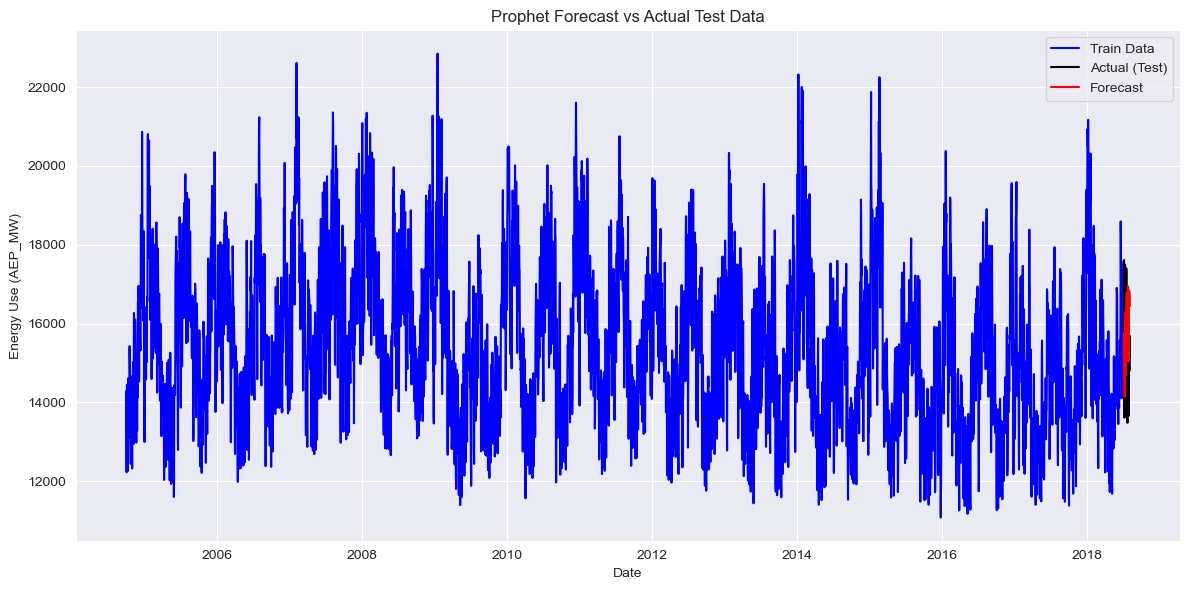

In [28]:

# Merge test with forecasted values
forecast_test = forecast[['ds', 'yhat']].set_index('ds').join(
    test.set_index('ds'), how='inner'
)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Train Data', color='blue')
plt.plot(test['ds'], test['y'], label='Actual (Test)', color='black')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Forecast', color='red')
plt.title('Prophet Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Energy Use (AEP_MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1046.02
RMSE: 1152.65


**Performance:**  
- **MAE:** 1,046.02 MW  
- **RMSE:** 1,152.65 MW  

**Observation:**  
- Forecast aligns well with actual test data, capturing seasonal variations.  
- Small deviations may be due to short-term anomalies not modeled by Prophet.


# Baseline Attempt: Linear Regression (Learning Step)
As part of my initial exploration, I applied a simple linear regression model to this time series data.  
While this was useful for practicing modeling in Python, I later learned that linear regression is not well-suited  
for capturing seasonality and temporal dependencies. I have kept this section to show the progression  
from basic models to more suitable forecasting techniques like Prophet.


In [18]:
# Changing Datetime column to numerical for applying linear regression 
df['Date']=df['Date'].map(dt.datetime.toordinal)

### Train-Test Splitting
Splitting the dataset into training and testing subsets
- Training set: Used to train the model
- Testing set: Used to evaluate the model on unseen data


In [19]:
#Spliting train and test set
split_index = int(0.8 * len(df))
train_df = df[:split_index]
test_df = df[split_index:]

In [20]:
# Defining X and Y sets for linear regression 
X_train =train_df['Date'].values.reshape(-1, 1) 
Y_train =train_df['AEP_MW']
X_test = test_df['Date'].values.reshape(-1, 1) 
Y_test= test_df['AEP_MW']

### Building and training a linear regression model
- The model uses the numerical date as the independent variable (X)
- The dependent variable (Y) is the energy consumption


In [21]:
#Fit the model
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [22]:
# Make predictions
predictions = model.predict(X_test)

In [15]:
predictions

array([14963.96561803, 14963.96561803, 14963.96561803, ...,
       14578.85755391, 14578.85755391, 14578.48402524])

### Visualization

Visualizing the actual vs predicted energy consumption values
- The red line represents actual consumption, while the blue line represents predictions
- A flat blue line suggests that the model struggles to capture patterns in the data


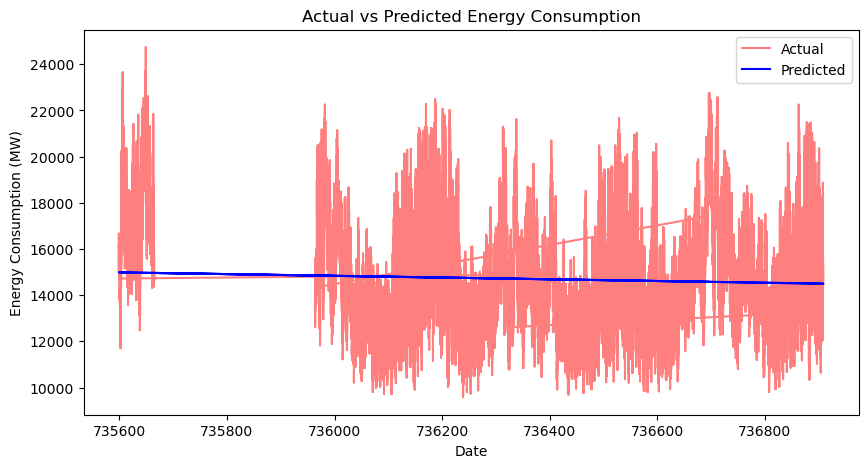

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(test_df['Date'], test_df['AEP_MW'], label='Actual', color='red', alpha=0.5)
plt.plot(test_df['Date'], predictions, label='Predicted', color='blue')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

### Model Evaluation

Evaluating the model using Mean Squared Error (MSE) and R² Score
- High MSE and negative R² score indicate poor performance, as the model fails to learn from the data


In [23]:
#Calculating mean squared error and r squared error 
mse = mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 6592019.565986139
R^2 Score: -0.00011300030399152838



**Observation:**  
- The model failed to capture seasonal cycles, confirming that a time series–specific method was needed.

